# SECTION 1: FLOOD DATA CLEANING AND ANALYSIS

In [11]:
from itertools import combinations
from statsmodels.formula.api import ols
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.filterwarnings('ignore')
import itertools as IT
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import seaborn as sns
import numpy as np
import math
from sqlalchemy import create_engine
from ydata_profiling import ProfileReport
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

(The flood data has fewer zipcodes than the housing data, so we have to match the latter on the former)

In [5]:
data = pd.read_csv('/Users/admin/Downloads/NFIP/nfip-flood-policies.csv', nrows=100)

Need to get county code for king county and filter this giant, 3 gig csv file by it

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 45 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   agriculturestructureindicator       0 non-null      float64
 1   basefloodelevation                  39 non-null     float64
 2   basementenclosurecrawlspacetype     100 non-null    int64  
 3   cancellationdateoffloodpolicy       13 non-null     object 
 4   censustract                         100 non-null    int64  
 5   condominiumindicator                100 non-null    object 
 6   construction                        100 non-null    object 
 7   countycode                          100 non-null    int64  
 8   crsdiscount                         100 non-null    float64
 9   deductibleamountinbuildingcoverage  98 non-null     float64
 10  deductibleamountincontentscoverage  92 non-null     float64
 11  elevatedbuildingindicator           100 non-nu

In [7]:
data.columns

Index(['agriculturestructureindicator', 'basefloodelevation',
       'basementenclosurecrawlspacetype', 'cancellationdateoffloodpolicy',
       'censustract', 'condominiumindicator', 'construction', 'countycode',
       'crsdiscount', 'deductibleamountinbuildingcoverage',
       'deductibleamountincontentscoverage', 'elevatedbuildingindicator',
       'elevationcertificateindicator', 'elevationdifference',
       'federalpolicyfee', 'floodzone', 'hfiaasurcharge',
       'houseofworshipindicator', 'latitude', 'locationofcontents',
       'longitude', 'lowestadjacentgrade', 'lowestfloorelevation',
       'nonprofitindicator', 'numberoffloorsininsuredbuilding',
       'obstructiontype', 'occupancytype', 'originalconstructiondate',
       'originalnbdate', 'policycost', 'policycount', 'policyeffectivedate',
       'policyterminationdate', 'policytermindicator',
       'postfirmconstructionindicator', 'primaryresidenceindicator',
       'propertystate', 'reportedzipcode', 'ratemethod',
    

In [8]:
file = '/Users/admin/Downloads/NFIP/nfip-flood-policies.csv'
df_empty = pd.DataFrame()
with open(file) as fl:
    chunk_iter = pd.read_csv(fl, chunksize = 100000, low_memory=False)
    for chunk in chunk_iter:
        chunk = chunk[chunk['countycode'] == 53033.0]
        df_empty = pd.concat([df_empty,chunk])

Inputting relevant-seeming columns and getting rid of nulls.

In [9]:
flood_data = df_empty[['countycode', 'deductibleamountinbuildingcoverage', 'elevatedbuildingindicator', 'elevationdifference', 'floodzone', 'reportedzipcode', 'totalinsurancepremiumofthepolicy']].copy()

In [10]:
df_empty.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 109936 entries, 147 to 50406466
Data columns (total 45 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   agriculturestructureindicator       17453 non-null   object 
 1   basefloodelevation                  19583 non-null   float64
 2   basementenclosurecrawlspacetype     109936 non-null  float64
 3   cancellationdateoffloodpolicy       11480 non-null   object 
 4   censustract                         109641 non-null  float64
 5   condominiumindicator                109936 non-null  object 
 6   construction                        109936 non-null  object 
 7   countycode                          109936 non-null  float64
 8   crsdiscount                         109936 non-null  float64
 9   deductibleamountinbuildingcoverage  103272 non-null  object 
 10  deductibleamountincontentscoverage  99339 non-null   object 
 11  elevatedbuildingindica

#### Clean zip codes. Should all be 5 digits and start with 9


In [12]:
flood_data.reportedzipcode = flood_data.reportedzipcode.astype(int)

In [13]:
flood_data.countycode = flood_data.countycode.astype(int)

In [14]:
flood_data = flood_data[(flood_data['reportedzipcode'] >= 90000) & (flood_data['reportedzipcode'] <= 99999)]

# Let's get the flood zone types per zipcode and create a dictionary, new column, and scores!!

In [15]:
flood_dict = flood_data.groupby(['reportedzipcode'])['floodzone'].apply(lambda grp: list(grp.value_counts().index)).to_dict()
flood_dict

{93002: ['X'],
 96168: ['X'],
 98000: ['X'],
 98001: ['X', 'AE', 'A', 'AH', 'C'],
 98002: ['X', 'AH', 'AE', 'AHB', 'C', 'AO'],
 98003: ['X'],
 98004: ['X', 'AE'],
 98005: ['X', 'AE', 'B'],
 98006: ['X', 'AE', 'A'],
 98007: ['X', 'AE'],
 98008: ['X', 'AE', 'A', 'C', 'A06'],
 98010: ['X', 'C'],
 98011: ['X', 'C', 'A06', 'AE'],
 98014: ['AE', 'X', 'AO', 'C', 'AOB', 'A', 'A05', 'A06'],
 98019: ['AE', 'X', 'A', 'C', 'A10'],
 98022: ['A', 'X', 'D', 'AE', 'C'],
 98023: ['X', 'A', 'C'],
 98024: ['AE', 'X', 'AO', 'C', 'A', 'AOB', 'A05'],
 98025: ['AE'],
 98027: ['AE', 'X', 'AO', 'A', 'A04', 'C', 'B', 'AOB', 'A02'],
 98028: ['AE', 'X', 'A'],
 98029: ['X', 'AE'],
 98030: ['X', 'AE', 'AH'],
 98031: ['X', 'AE', 'A', 'C'],
 98032: ['X', 'AE', 'AHB', 'AH', 'C', 'A', 'VE'],
 98033: ['X', 'AO'],
 98034: ['X'],
 98035: ['AE', 'X'],
 98038: ['AE', 'X', 'A05', 'B', 'A', 'C', 'A01'],
 98039: ['X'],
 98040: ['X'],
 98042: ['X', 'A', 'AE'],
 98045: ['AE',
  'AO',
  'X',
  'AOB',
  'D',
  'C',
  'A',
  'AH',


#### We use different values (1 or 2) for  X (which is a very common category, because X can mean either moderate or low risk. When I attempted to use the value of 1.5, i kept getting an error about using floats, so instead we are created a 3rd column with the average of these two.

#### We end up with a 3 flood score columns which reflect conservative, moderate, and low conservative values

In [16]:
flood_data.head()

,countycode,deductibleamountinbuildingcoverage,elevatedbuildingindicator,elevationdifference,floodzone,reportedzipcode,totalinsurancepremiumofthepolicy
147,53033,1,N,999.0,X,98055,335.0
216,53033,1,N,999.0,X,98002,375.0
483,53033,1,N,999.0,X,98002,335.0
800,53033,0,N,999.0,X,98133,1818.0
1261,53033,1,N,999.0,X,98001,335.0


In [31]:
unique_values = sorted(set(value for sublist in flood_dict.values() for value in sublist))
dict_keys = list(unique_values)
dict_values = [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2,1,1,3,2]
score_dict_1 = dict(zip(dict_keys, dict_values))

score_dict_1

{'A': 3,
 'A01': 3,
 'A02': 3,
 'A03': 3,
 'A04': 3,
 'A05': 3,
 'A06': 3,
 'A07': 3,
 'A09': 3,
 'A10': 3,
 'A11': 3,
 'A12': 3,
 'AE': 3,
 'AH': 3,
 'AHB': 3,
 'AO': 3,
 'AOB': 3,
 'B': 2,
 'C': 1,
 'D': 1,
 'VE': 3,
 'X': 2}

In [28]:
unique_values = sorted(set(value for sublist in flood_dict.values() for value in sublist))
dict_keys = list(unique_values)
dict_values = [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,2,1,1,3,1]
score_dict_2 = dict(zip(dict_keys, dict_values))

score_dict_2

{'A': 3,
 'A01': 3,
 'A02': 3,
 'A03': 3,
 'A04': 3,
 'A05': 3,
 'A06': 3,
 'A07': 3,
 'A09': 3,
 'A10': 3,
 'A11': 3,
 'A12': 3,
 'AE': 3,
 'AH': 3,
 'AHB': 3,
 'AO': 3,
 'AOB': 3,
 'B': 2,
 'C': 1,
 'D': 1,
 'VE': 3,
 'X': 1}

In [32]:
flood_data['area flood score 1'] = flood_data['floodzones in zipcode'].apply(lambda x: [score_dict_1[val] for val in x]).apply(lambda x: sum(x) / len(x))


In [33]:
flood_data['area flood score 2'] = flood_data['floodzones in zipcode'].apply(lambda x: [score_dict_2[val] for val in x]).apply(lambda x: sum(x) / len(x))


In [34]:
flood_data['average flood score'] = (flood_data['area flood score 1'] + flood_data['area flood score 2']) / 2

In [35]:
flood_data.head()

,countycode,deductibleamountinbuildingcoverage,elevatedbuildingindicator,elevationdifference,floodzone,reportedzipcode,totalinsurancepremiumofthepolicy,floodzones in zipcode,area flood score 2,area flood score 1,average flood score
147,53033,1,N,999.0,X,98055,335.0,"[X, AHB, AE]",2.333333,2.666667,2.500000
216,53033,1,N,999.0,X,98002,375.0,"[X, AH, AE, AHB, C, AO]",2.333333,2.500000,2.416667
483,53033,1,N,999.0,X,98002,335.0,"[X, AH, AE, AHB, C, AO]",2.333333,2.500000,2.416667
800,53033,0,N,999.0,X,98133,1818.0,"[X, A, AE, C]",2.000000,2.250000,2.125000
1261,53033,1,N,999.0,X,98001,335.0,"[X, AE, A, AH, C]",2.200000,2.400000,2.300000


In [36]:
flood_data.columns

Index(['countycode', 'deductibleamountinbuildingcoverage',
       'elevatedbuildingindicator', 'elevationdifference', 'floodzone',
       'reportedzipcode', 'totalinsurancepremiumofthepolicy',
       'floodzones in zipcode', 'area flood score 2', 'area flood score 1',
       'average flood score'],
      dtype='object')

# Dropping everything that isn't about zipcodes and flood data. 

In [39]:
flood_data.drop(['countycode','totalinsurancepremiumofthepolicy', 'elevatedbuildingindicator','elevationdifference','floodzone', 'deductibleamountinbuildingcoverage'], axis=1, inplace=True)

In [40]:
flood_data.columns

Index(['reportedzipcode', 'floodzones in zipcode', 'area flood score 2',
       'area flood score 1', 'average flood score'],
      dtype='object')

In [41]:
#Renaming zipcode column
flood_data.rename(columns={'reportedzipcode': 'zipcode'}, inplace=True)

In [ ]:
# we then saved this to csv
# flood_data.to_csv('flood_data.csv', index=False)

# SECTION 2: HOUSING DATA CLEANING AND ANALYSIS


###### Importing Libraries, Intitial Look at Housing Data

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from scipy import stats
import seaborn as sns
import numpy as np
import math

In [4]:
df = pd.read_csv('/Users/admin/Documents/Flatiron/Housing_Prices_and_Flood_Risk/data/kc_house_data.csv')

In [44]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'greenbelt', 'nuisance', 'view',
       'condition', 'grade', 'heat_source', 'sewer_system', 'sqft_above',
       'sqft_basement', 'sqft_garage', 'sqft_patio', 'yr_built',
       'yr_renovated', 'address', 'lat', 'long'],
      dtype='object')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30155 entries, 0 to 30154
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             30155 non-null  int64  
 1   date           30155 non-null  object 
 2   price          30155 non-null  float64
 3   bedrooms       30155 non-null  int64  
 4   bathrooms      30155 non-null  float64
 5   sqft_living    30155 non-null  int64  
 6   sqft_lot       30155 non-null  int64  
 7   floors         30155 non-null  float64
 8   waterfront     30155 non-null  object 
 9   greenbelt      30155 non-null  object 
 10  nuisance       30155 non-null  object 
 11  view           30155 non-null  object 
 12  condition      30155 non-null  object 
 13  grade          30155 non-null  object 
 14  heat_source    30123 non-null  object 
 15  sewer_system   30141 non-null  object 
 16  sqft_above     30155 non-null  int64  
 17  sqft_basement  30155 non-null  int64  
 18  sqft_g

In [6]:
df['address'].sample

<bound method NDFrame.sample of 0        2102 Southeast 21st Court, Renton, Washington ...
1        11231 Greenwood Avenue North, Seattle, Washing...
2        8504 South 113th Street, Seattle, Washington 9...
3        4079 Letitia Avenue South, Seattle, Washington...
4        2193 Northwest Talus Drive, Issaquah, Washingt...
                               ...                        
30150    4673 Eastern Avenue North, Seattle, Washington...
30151    4131 44th Avenue Southwest, Seattle, Washingto...
30152    910 Martin Luther King Jr Way, Seattle, Washin...
30153    17127 114th Avenue Southeast, Renton, Washingt...
30154    18615 7th Avenue South, Burien, Washington 981...
Name: address, Length: 30155, dtype: object>

In [7]:
df.describe(include="all")

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,greenbelt,...,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio,yr_built,yr_renovated,address,lat,long
count,3.015500e+04,30155,3.015500e+04,30155.000000,30155.000000,30155.000000,3.015500e+04,30155.000000,30155,30155,...,30141,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155.000000,30155,30155.000000,30155.000000
unique,NaN,365,NaN,NaN,NaN,NaN,NaN,NaN,2,2,...,4,NaN,NaN,NaN,NaN,NaN,NaN,29560,NaN,NaN
top,NaN,7/1/2021,NaN,NaN,NaN,NaN,NaN,NaN,NO,NO,...,PUBLIC,NaN,NaN,NaN,NaN,NaN,NaN,"Avenue, 108 Foothill Blvd, Rancho Cucamonga, C...",NaN,NaN
freq,NaN,196,NaN,NaN,NaN,NaN,NaN,NaN,29636,29382,...,25777,NaN,NaN,NaN,NaN,NaN,NaN,38,NaN,NaN
mean,4.538104e+09,NaN,1.108536e+06,3.413530,2.334737,2112.424739,1.672360e+04,1.543492,NaN,NaN,...,NaN,1809.826098,476.039396,330.211142,217.412038,1975.163953,90.922301,NaN,47.328076,-121.317397
std,2.882587e+09,NaN,8.963857e+05,0.981612,0.889556,974.044318,6.038260e+04,0.567717,NaN,NaN,...,NaN,878.306131,579.631302,285.770536,245.302792,32.067362,416.473038,NaN,1.434005,5.725475
min,1.000055e+06,NaN,2.736000e+04,0.000000,0.000000,3.000000,4.020000e+02,1.000000,NaN,NaN,...,NaN,2.000000,0.000000,0.000000,0.000000,1900.000000,0.000000,NaN,21.274240,-157.791480
25%,2.064175e+09,NaN,6.480000e+05,3.000000,2.000000,1420.000000,4.850000e+03,1.000000,NaN,NaN,...,NaN,1180.000000,0.000000,0.000000,40.000000,1953.000000,0.000000,NaN,47.405320,-122.326045
50%,3.874011e+09,NaN,8.600000e+05,3.000000,2.500000,1920.000000,7.480000e+03,1.500000,NaN,NaN,...,NaN,1560.000000,0.000000,400.000000,150.000000,1977.000000,0.000000,NaN,47.551380,-122.225585
75%,7.287100e+09,NaN,1.300000e+06,4.000000,3.000000,2619.500000,1.057900e+04,2.000000,NaN,NaN,...,NaN,2270.000000,940.000000,510.000000,320.000000,2003.000000,0.000000,NaN,47.669913,-122.116205


Should be able to drop nulls, since they are only a small ratio and only in 2 columns 
(heat_source and sewer_system). need to check and make sure there aren't other null values (encoded, for instance,
as zeroes)

Location is of course going to be fundamental, so need to parse the address data as separate strings to. May also be able to use lat/long, but must be mindful of this creating collinearity

Given interest in climate change effects (pre-determined), flooding might be easiest to look at. do these prices relate to flood-prone areas? how might these values shift given the effects of climate change? look at "greenbelt", "grade", "lat", "long", "waterfront" etc. We can't do a lot of EDA here since we are really looking for correspondences with data that doesn't exist yet.

Random sampling indicates the coordinates do match up exactly with street addresses

Got relevant flood data as a csv file. now need to clean this data so we can merge on a common column, which
in this case in zip code

# Initial cleaning for merge

For some reason can't get this to work and must've deleted the work-around. in any case, I did 
split out all the address info and saved it as a csv.
We did NOT have to worry about bad zipcodes/cities/states as we had already accounted for that
by merging on the good flood data.

In [10]:

#df[['street address', 'city', 'state']] = df['address'].str.split(',', expand=True)
#df['street address'] = df['street address'].str.strip()
#df['city'] = df['city'].str.strip()
#df['state'] = df['state'].str.strip()
#df['zipcode'] = df['zipcode'].str.strip()

#df.to_csv('housing_cleaned_addresses.csv', index=False)


# SECTION 3: MERGED FLOOD AND HOUSING DATA CLEANING AND EDA WITH TEST/TRAIN SPLITTING


In [2]:
df = pd.read_csv('/Users/admin/Documents/Flatiron/Housing_Prices_and_Flood_Risk/data/merged_df.csv')

In [3]:
df.iloc[:, 10:20]

,nuisance,view,condition,grade,heat_source,sewer_system,sqft_above,sqft_basement,sqft_garage,sqft_patio
0,NO,NONE,Good,7 Average,Gas,PUBLIC,1180,0,0,40
1,NO,NONE,Average,7 Average,Gas,PUBLIC,930,930,240,90
2,NO,NONE,Average,7 Average,Gas,PUBLIC,1240,1240,490,60
3,NO,NONE,Good,6 Low Average,Electricity,PUBLIC,1400,0,330,330
4,NO,NONE,Average,8 Good,Gas,PUBLIC,1190,590,420,200
...,...,...,...,...,...,...,...,...,...,...
29183,NO,NONE,Average,6 Low Average,Electricity,PRIVATE,1010,0,0,180
29184,YES,NONE,Average,6 Low Average,Electricity,PRIVATE,480,0,0,0
29185,YES,AVERAGE,Fair,6 Low Average,Electricity,PRIVATE,1040,0,0,0
29186,YES,NONE,Average,5 Fair,NaN,PRIVATE,1260,0,0,110


### Using Profile Report to gather statistics about our data

In [5]:
sample = df.sample(10000)

profile_2 = ProfileReport(sample, minimal=True)
profile_2.to_file("output.html")
profile_2

## CREATING TRAIN/TEST DATA BEFORE CLEANING! 

In [12]:
#https://towardsdatascience.com/avoid-data-leakage-split-your-data-before-processing-a7f172632b00
X = df.drop('price', axis = 1)
y = df['price']

In [13]:
#setting values for test train (30, 70)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [14]:
df = pd.concat([X_train, y_train], axis = 1)

### Assigning numeric values to categorical data, deleting, renaming, etc.

In [15]:
df['grade score'] = df['grade'].str.split().str[0]

In [16]:
df['grade score'] = df['grade score'].astype(int)

In [17]:
df.drop(labels='grade', axis=1, inplace=True)

In [18]:
df['condition'].value_counts()

Average      12364
Good          5619
Very Good     2254
Fair           148
Poor            46
Name: condition, dtype: int64

In [19]:
df['has_basement'] = df['sqft_basement'].apply(lambda x: 1 if x > 0 else 0)

In [20]:
df['on_waterfront'] = df['waterfront'].apply(lambda x: 0 if x == "NO" else 1)

In [21]:
df['near_greenbelt'] = df['greenbelt'].apply(lambda x: 0 if x == "NO" else 1)

In [22]:
df.drop(labels='greenbelt', axis=1, inplace=True)

In [23]:
df.drop(labels='waterfront', axis=1, inplace=True)

In [24]:
df['date'] = pd.to_datetime(df['date'])

In [25]:
df['view'].value_counts()

NONE         17981
AVERAGE       1312
GOOD           599
EXCELLENT      386
FAIR           153
Name: view, dtype: int64

In [26]:
category_labels = {'NONE': 0,
                   'FAIR': 1,
                   'AVERAGE': 2,
                   'GOOD': 3, 
                   'EXCELLENT': 4}
    

# Create a new column 'Label' based on the dictionary values corresponding to the 'Category' column
df['view score'] = df['view'].map(category_labels)

In [27]:
df['condition'].value_counts()

Average      12364
Good          5619
Very Good     2254
Fair           148
Poor            46
Name: condition, dtype: int64

In [28]:
df['nuisance_2'] = df['nuisance'].apply(lambda x: 1 if x == "YES" else 0)

In [29]:
df.drop(labels='nuisance', axis=1, inplace=True)

In [30]:
df.rename(columns={'nuisance_2': 'nuisance'}, inplace=True)

In [31]:
category_labels_2 = {'Poor': 1,
                   'Fair': 2,
                   'Average': 3,
                   'Good': 4, 
                   'Very Good': 5}
    

# Create a new column 'Label' based on the dictionary values corresponding to the 'Category' column
df['condition score'] = df['condition'].map(category_labels_2)

In [32]:
df.drop(labels='condition', axis=1, inplace=True)

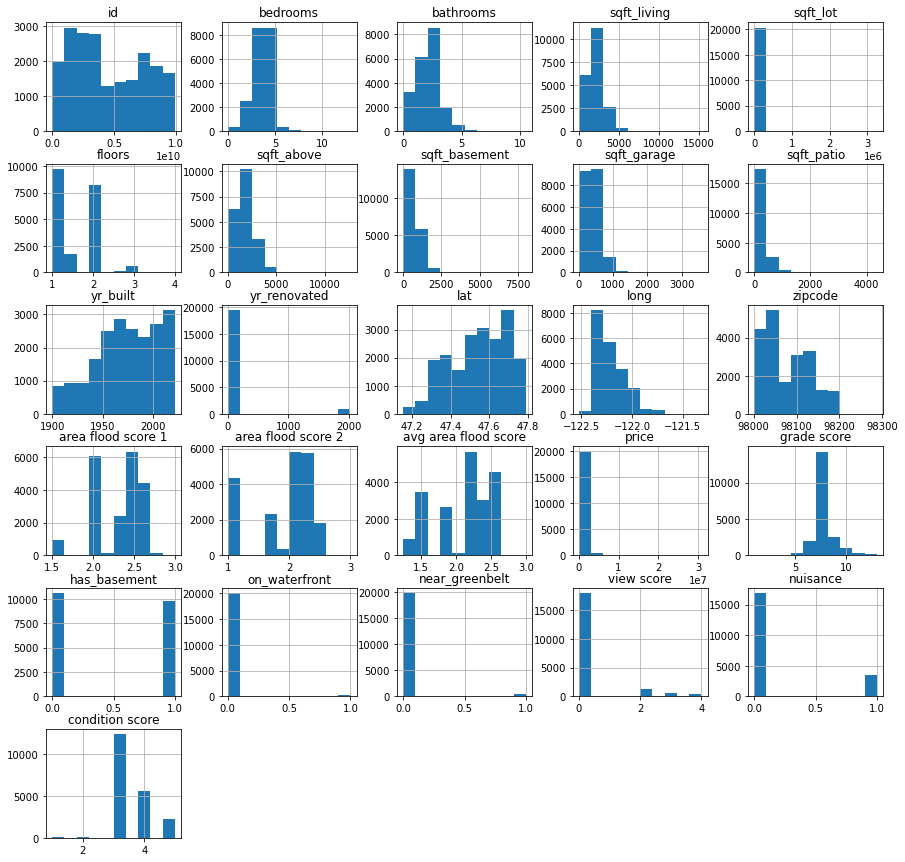

In [33]:
df.hist(figsize = (15,15))
plt.show()

## Have a lot of outliers, based on above. Will remove > 3 std deviations

In [39]:
def remove_outliers(df):
    variables = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 
              'sqft_patio', 'sqft_garage', 'sqft_basement']
    
    for variable in variables:
        df = df[np.abs(df[variable]-df[variable].mean()) <= (3*df[variable].std())]
        
    return df

In [40]:
df_2 = remove_outliers(df)

In [36]:
df_2.sample(10)

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,view,heat_source,sewer_system,...,area flood score 2,avg area flood score,price,grade score,has_basement,on_waterfront,near_greenbelt,view score,nuisance,condition score
16340,5015001330,2022-01-24,4,4.0,2860,4000,2.0,NONE,Gas,PUBLIC,...,1.000000,1.500000,1252000.0,8,1,0,0,0,0,5
13588,1245001555,2022-04-28,5,2.0,2180,8650,1.0,NONE,Gas,PUBLIC,...,2.000000,2.250000,1700000.0,7,1,0,0,0,0,4
26868,1336300080,2021-10-20,5,4.5,4090,8040,2.5,AVERAGE,Gas,PUBLIC,...,1.000000,1.500000,2505000.0,9,1,0,0,2,1,4
997,9368700105,2022-02-08,3,2.0,2120,5264,1.0,NONE,Gas,PUBLIC,...,2.000000,2.250000,780000.0,6,1,0,0,0,1,5
26048,3179100310,2021-12-16,2,1.5,1670,6000,1.0,NONE,Oil,PUBLIC,...,1.000000,1.500000,960000.0,8,1,0,0,0,0,3
9470,2768100616,2021-11-04,2,2.0,840,563,3.0,NONE,Electricity,PUBLIC,...,1.000000,1.250000,586500.0,8,0,0,0,0,0,3
19907,9126100156,2022-03-16,2,1.0,990,2550,1.0,NONE,Gas,PUBLIC,...,1.000000,1.500000,754321.0,6,0,0,0,0,0,4
5557,2883200645,2021-11-12,3,2.0,2470,6700,1.5,NONE,Gas,PUBLIC,...,1.000000,1.500000,1662000.0,8,1,0,0,0,0,4
25053,8641500282,2021-11-22,2,1.5,840,873,2.0,NONE,Gas,PUBLIC,...,1.666667,1.833333,489000.0,7,0,0,0,0,0,3
25881,4206901315,2022-04-13,4,3.5,3290,4000,3.0,NONE,Gas,PUBLIC,...,1.000000,1.500000,2530000.0,9,1,0,0,0,1,3


In [41]:

df.shape[0] - df_2.shape[0]

1440

### We lost 1400 rows out of 18000, so seems ok to proceed.

In [42]:
df = remove_outliers(df)

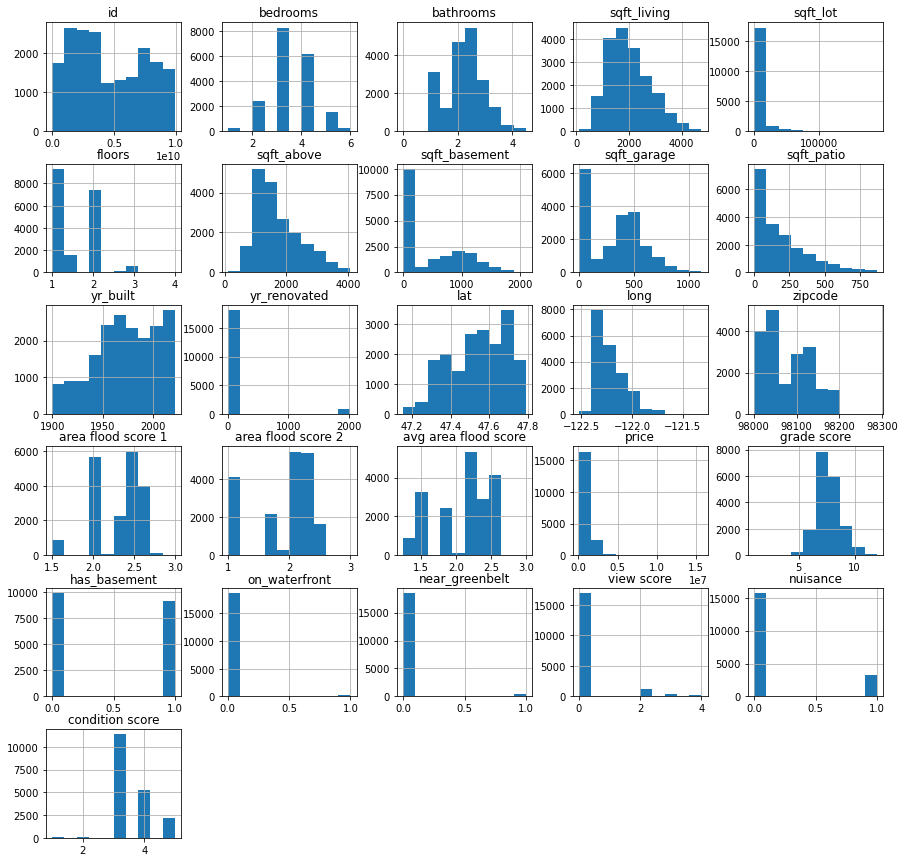

In [43]:
df.hist(figsize = (15,15))
plt.show()

### Need to look at price outliers, though


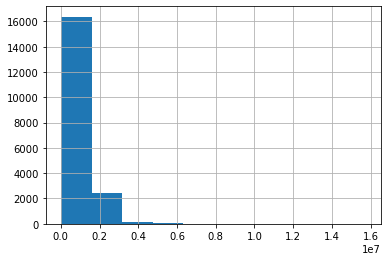

In [44]:
df['price'].hist()
plt.show()

In [47]:
quantile_99 = df['price'].quantile(q = .99)
quantile_99

3200000.0

### 99 percentile seems like a good cut-off price. Our target is middle-upper class but not super-wealthy.

In [51]:
df = df[df['price']<=3200000]

## #Now that we've got a good initial cleaned up test data set, let's look at correlations.

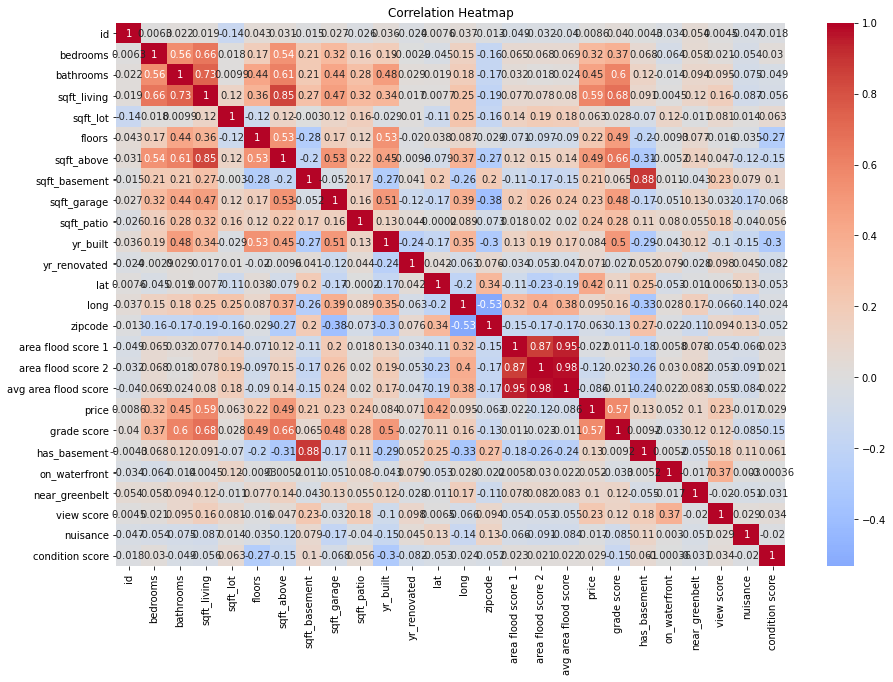

In [53]:
corr = df.corr()

plt.figure(figsize = (15,10))
sns.heatmap(corr, center = 0, annot = True, cmap = 'coolwarm')
plt.title('Correlation Heatmap')
plt.show()

## Ended up deciding to keep correlated items; we just have to control for them in modelling.

In [56]:
#created csv
#df.to_csv('train_cleaned.csv', index=False)

In [58]:
#creating test data, cleaning in same way per researchgate

dftest = X_test.copy()
dftest = pd.concat([X_test, y_test], axis = 1)

In [60]:
dftest['grade score'] = dftest['grade'].str.split().str[0]
dftest['grade score'] = dftest['grade score'].astype(int)
dftest.drop(labels='grade', axis=1, inplace=True)
dftest['has_basement'] = dftest['sqft_basement'].apply(lambda x: 1 if x > 0 else 0)
dftest['on_waterfront'] = dftest['waterfront'].apply(lambda x: 0 if x == "NO" else 1)
dftest.drop(labels='waterfront', axis=1, inplace=True)
dftest['near_greenbelt'] = dftest['greenbelt'].apply(lambda x: 0 if x == "NO" else 1)
dftest.drop(labels='greenbelt', axis=1, inplace=True)
dftest['date'] = pd.to_datetime(dftest['date'])

category_labels = {'NONE': 0,
                   'FAIR': 1,
                   'AVERAGE': 2,
                   'GOOD': 3, 
                   'EXCELLENT': 4}

dftest['view score'] = dftest['view'].map(category_labels)
dftest.drop(labels='view', axis=1, inplace=True)
dftest['nuisance_2'] = dftest['nuisance'].apply(lambda x: 1 if x == "YES" else 0)
dftest.drop(labels='nuisance', axis=1, inplace=True)
dftest.rename(columns={'nuisance_2': 'nuisance'}, inplace=True)
category_labels_2 = {'Poor': 1,
                   'Fair': 2,
                   'Average': 3,
                   'Good': 4, 
                   'Very Good': 5}
dftest['condition score'] = dftest['condition'].map(category_labels_2)
dftest.drop(labels='condition', axis=1, inplace=True)
df_3 = remove_outliers(dftest)
quantile_99 = dftest['price'].quantile(q = .99)
dftest = dftest[dftest['price']<=quantile_99]

dftest.drop(labels=['heat_source', 'sewer_system'], axis=1, inplace=True)


In [ ]:
#created test data

#dftest.to_csv('test_cleaned.csv', index=False)